In [1]:
import cv2
import matplotlib.pyplot as plt
# import pandas as pd
import tensorflow as tf
import keras
import os
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
PATH = "/mnt/d/Datasets/"
data_path = PATH + "Inbreast/full/"
img_height = 300
img_width = 300
batch_size = 8
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

2023-02-13 00:16:39.373416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 00:16:40.120822: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-02-13 00:16:40.120913: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugi

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
(train_examples, validation_examples), info = tfds.load( 'curated_breast_imaging_ddsm', split=['train[:80%]', 'train[80%:]'])

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 4/4 [00:00<00:00, 69.69 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 4/4 [00:00<00:00, 62.86 url/s]


AssertionError: Manual directory /home/jj/tensorflow_datasets/downloads/manual does not exist or is empty. Create it and download/extract dataset artifacts in there using instructions:
You can download the images from
https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM

Because special software and libraries are needed to download and read the
images contained in the dataset, TFDS assumes that the user has downloaded the
original DCIM files and converted them to PNG.

The following commands (or equivalent) should be used to generate the PNG
files, in order to guarantee reproducible results:

```sh
find $DATASET_DCIM_DIR -name '*.dcm' | \
xargs -n1 -P8 -I{} bash -c 'f={}; dcmj2pnm $f | convert - ${f/.dcm/.png}'
```

Resulting images should be put in `manual_dir`, like:
`<manual_dir>/Mass-Training_P_01981_RIGHT_MLO_1/1.3.6.../000000.png`.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_path+'train/',
  label_mode="categorical",
  # validation_split=0.2,
  # subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path+'val/',
  label_mode="categorical",
  # validation_split=0.2,
  # subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1425 files belonging to 2 classes.


2023-02-13 00:01:11.745547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 00:01:11.746357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-13 00:01:11.746421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-13 00:01:11.746438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Found 54 files belonging to 2 classes.


In [7]:
preprocessing = preprocess_input
pre_trained = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
pre_trained.trainable = False

#Define model architect
tfinput = Input(shape=(img_height,img_width,3))
pre_process = preprocessing(tfinput)
effnetv2m_model=pre_trained(pre_process,training=False)
flatten = tf.keras.layers.Flatten()(effnetv2m_model)
x = Dense(8,activation = 'relu')(flatten)
x = Dense(8,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8,activation='relu')(x)
output = Dense(2, activation="softmax",kernel_regularizer=regularizers.l2(0.1))(x)
model = Model(tfinput,output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_aug = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds_aug= val_ds.prefetch(buffer_size=AUTOTUNE)

# initialising

In [9]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)]
    # ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_Inbreast/dense_checkpoint_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

In [10]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 10
dense_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_categorical_accuracy'])

Epoch 1/10


2023-02-13 00:01:29.173927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-13 00:01:45.913782: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-13 00:01:45.926728: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-13 00:01:45.937609: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

 60/179 [=========>....................] - ETA: 47s - loss: 1.1429 - categorical_accuracy: 0.5167 - recall: 0.2574 - recall_1: 0.7695

KeyboardInterrupt: 

# fine tuning

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 300, 300, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 300, 300, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1048

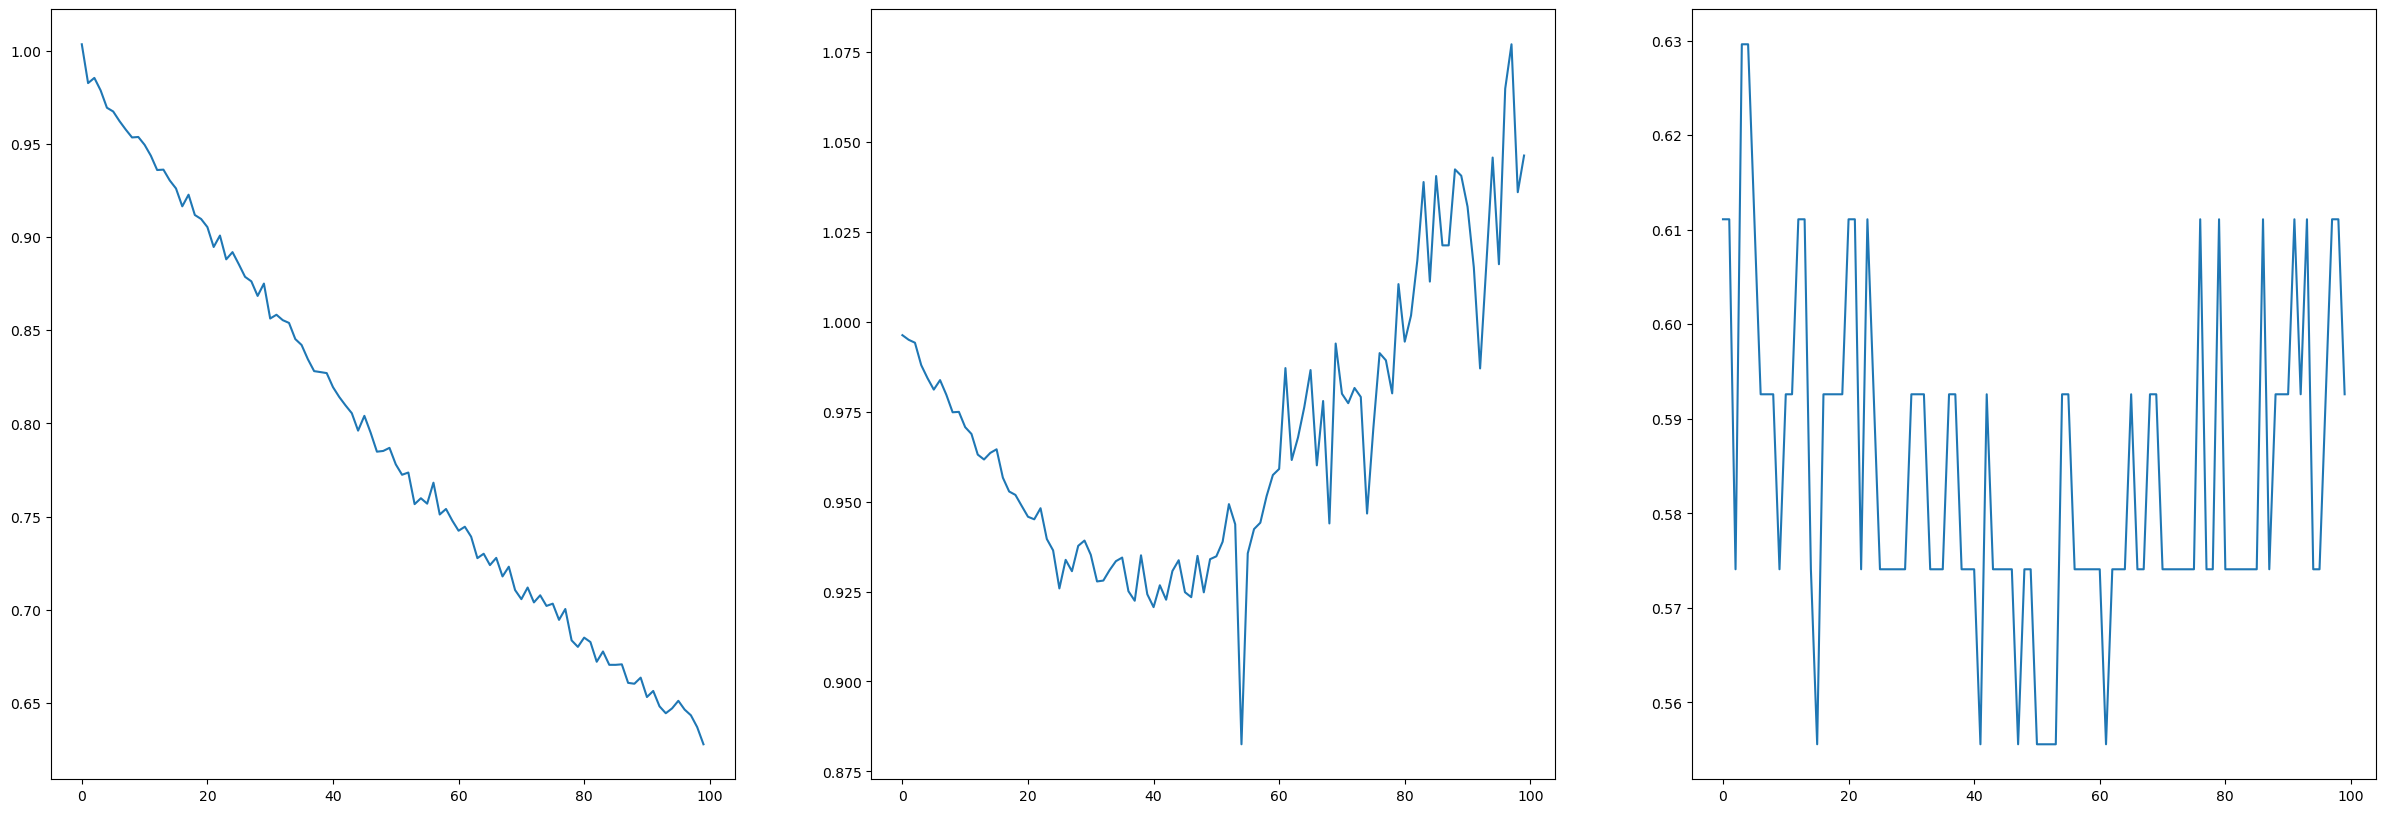

In [16]:
#load model with best performance
# model.load_weights("/home/jj/FYP/Checkpoint/EfficientNet/dense_init_checkpoint/cp-0010.ckpt")
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/InceptionV3_Inbreast/dense_checkpoint')
model.load_weights(latest)

pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-63]:
  layer.trainable = False
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/InceptionV3_Inbreast/fine_tuning_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/InceptionV3_Inbreast/fine_tuning_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_categorical_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
model.compile(
    optimizer= tf.keras.optimizers.SGD(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)]
)
model.summary()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=1,min_lr=1e-6)

total_epochs=100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=initial_epoch
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
    # initial_epoch=total_epochs
    # all_hist = np.append(all_hist,history_init)
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_categorical_accuracy'])

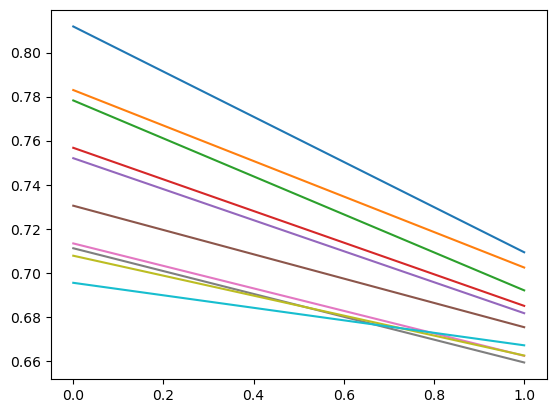

In [24]:

plt.plot([all_hist[0].history['loss'],all_hist[1].history['loss']])

Epoch 1/100
143/143 [==============================] - ETA: 0s - loss: 0.6452 - binary_accuracy: 0.6123
Epoch 1: val_loss improved from inf to 0.64529, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.59895, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2/cp-0001.ckpt
143/143 [==============================] - 40s 223ms/step - loss: 0.6452 - binary_accuracy: 0.6123 - val_loss: 0.6453 - val_binary_accuracy: 0.5989
Epoch 2/100
143/143 [==============================] - ETA: 0s - loss: 0.6257 - binary_accuracy: 0.6434
Epoch 2: val_loss improved from 0.64529 to 0.63677, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-0002.ckpt

Epoch 2: val_binary_accuracy did not improve from 0.59895
143/143 [==============================] - 29s 199ms/step - loss: 0.6257 - binary_accuracy: 0.6434 - val_loss: 0.6368 - va

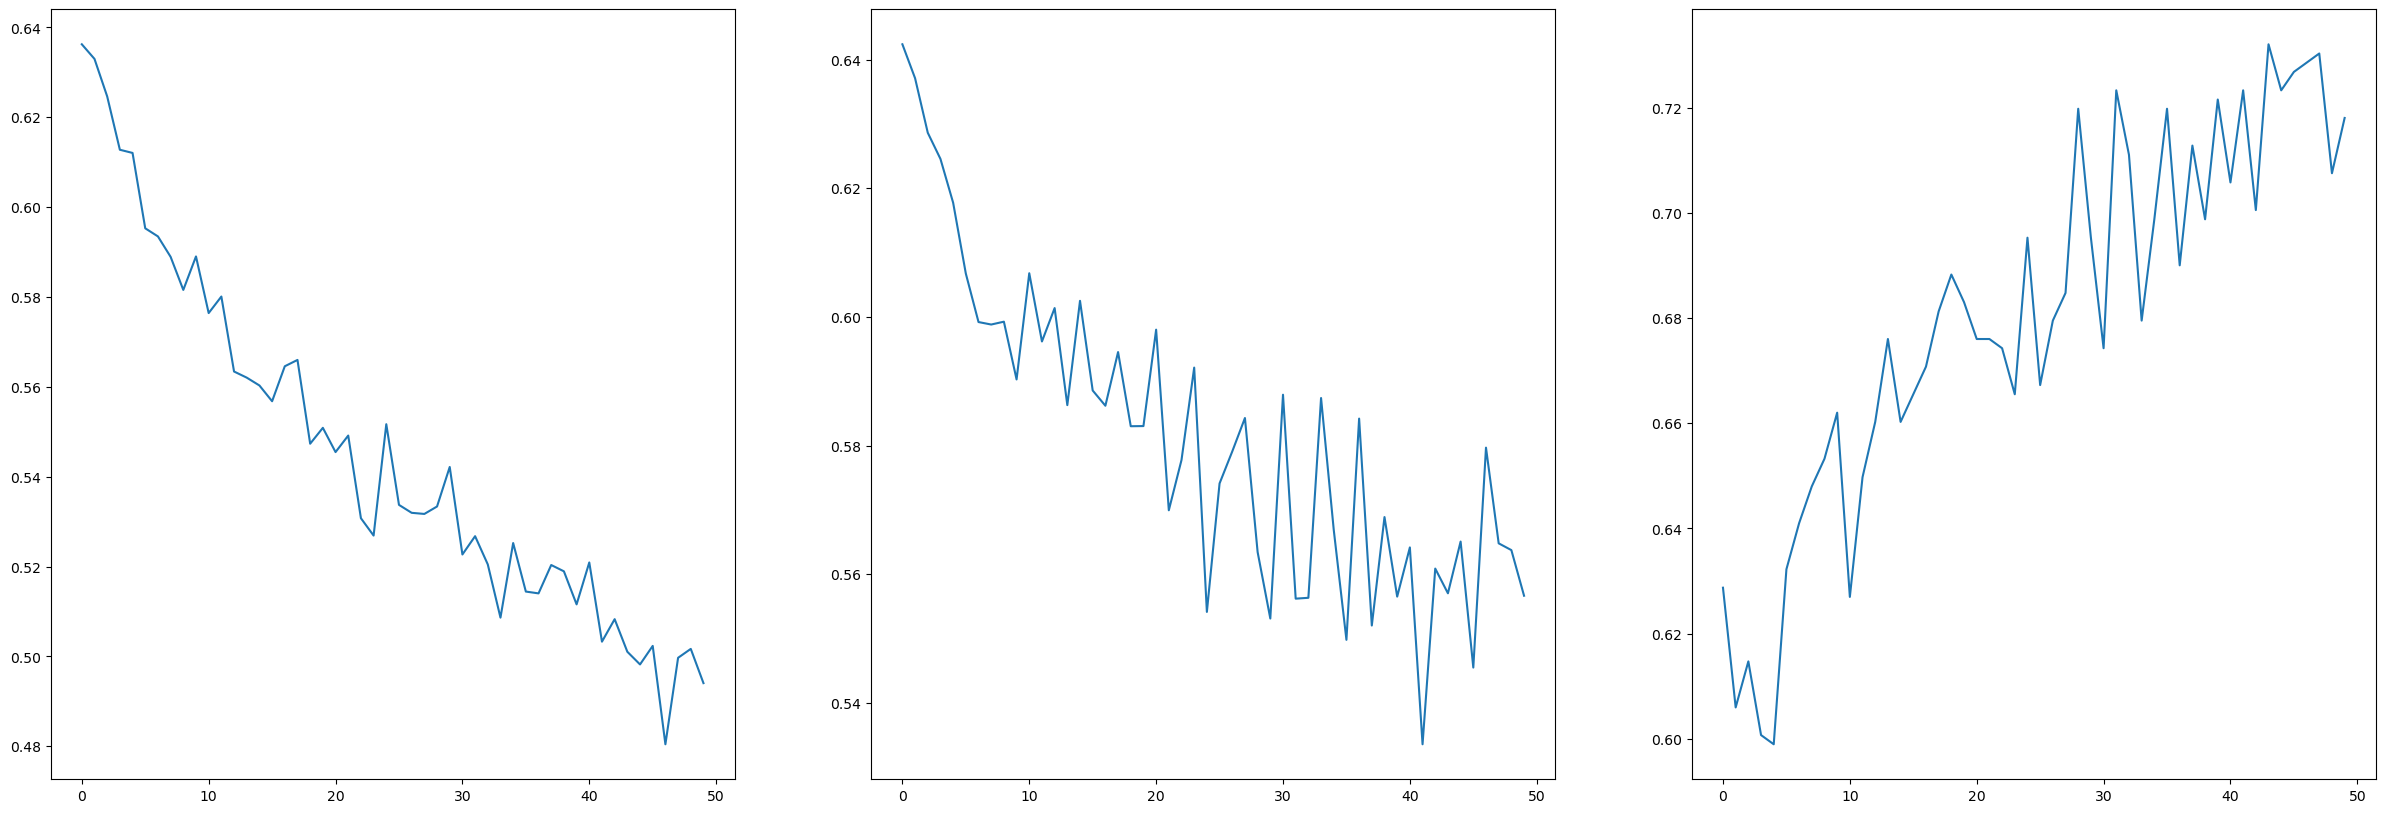

In [16]:
# Test with different optimiser
# latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNetV2_cbis_ddsm/fine_tuning_checkpoint_acc')
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNetV2_cbis_ddsm/dense_init_checkpoint_2')
model.load_weights(latest)
init_lr = 1e-5
steps = 10000
final_lr = 1e-6
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(lr_schedule),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # ,jit_compile=True
)
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_acc_2/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_ft_2 = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])

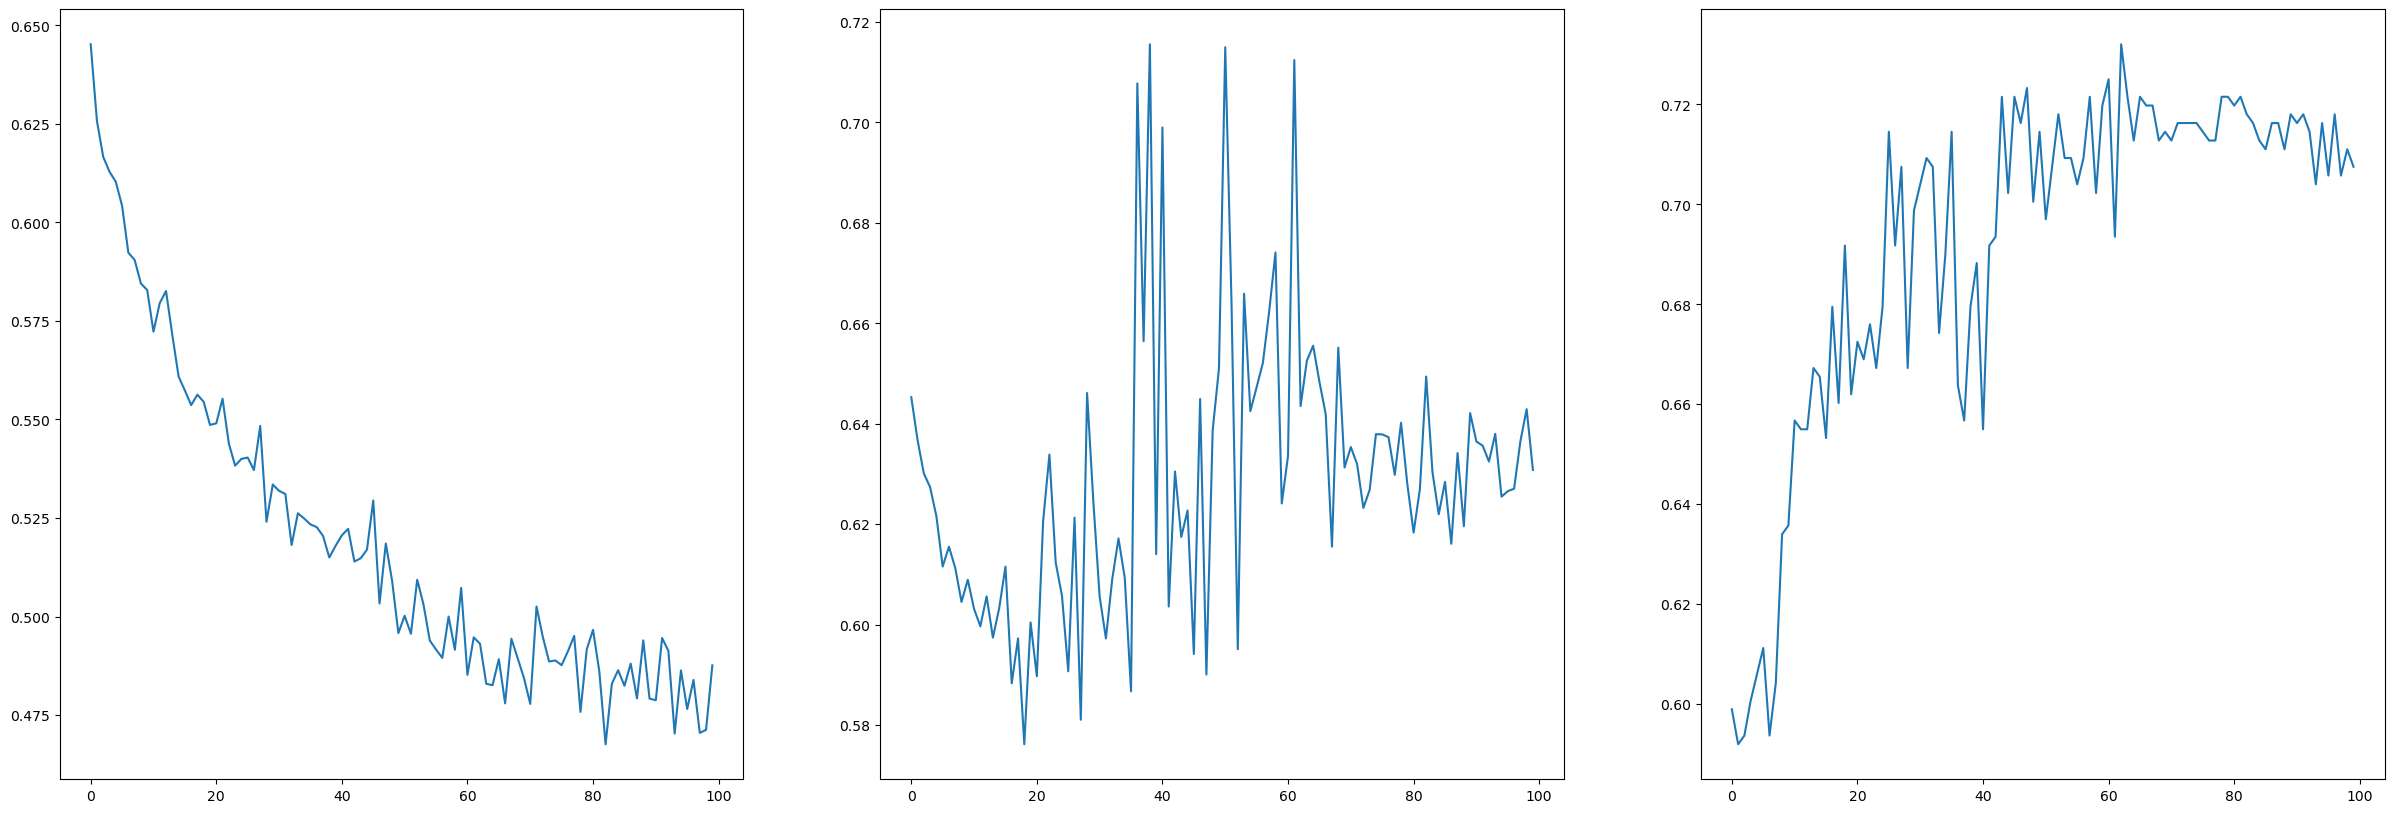

In [17]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_ft_2.history['loss'])
plt.subplot(132)
plt.plot(history_ft_2.history['val_loss'])
plt.subplot(133)
plt.plot(history_ft_2.history['val_binary_accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              131174

2023-02-02 07:44:44.861360: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.861406: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2023-02-02 07:44:44.967682: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


142/142 [==============================] - ETA: 0s - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000
Epoch 1: val_loss improved from inf to 0.56650, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-0001.ckpt

Epoch 1: val_binary_accuracy improved from -inf to 0.72261, saving model to /home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-0001.ckpt
142/142 [==============================] - 79s 494ms/step - loss: 0.5828 - binary_accuracy: 0.6829 - false_positives_1: 247.0000 - false_negatives_1: 471.0000 - val_loss: 0.5665 - val_binary_accuracy: 0.7226 - val_false_positives_1: 72.0000 - val_false_negatives_1: 85.0000
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 0.5779 - binary_accuracy: 0.6921 - false_positives_1: 215.0000 - false_negatives_1: 482.0000
Epoch 2: val_loss improved from 0.56650 to 0.55574, saving model to /home/jj/FYP/Checkpoint/EfficientNet_d

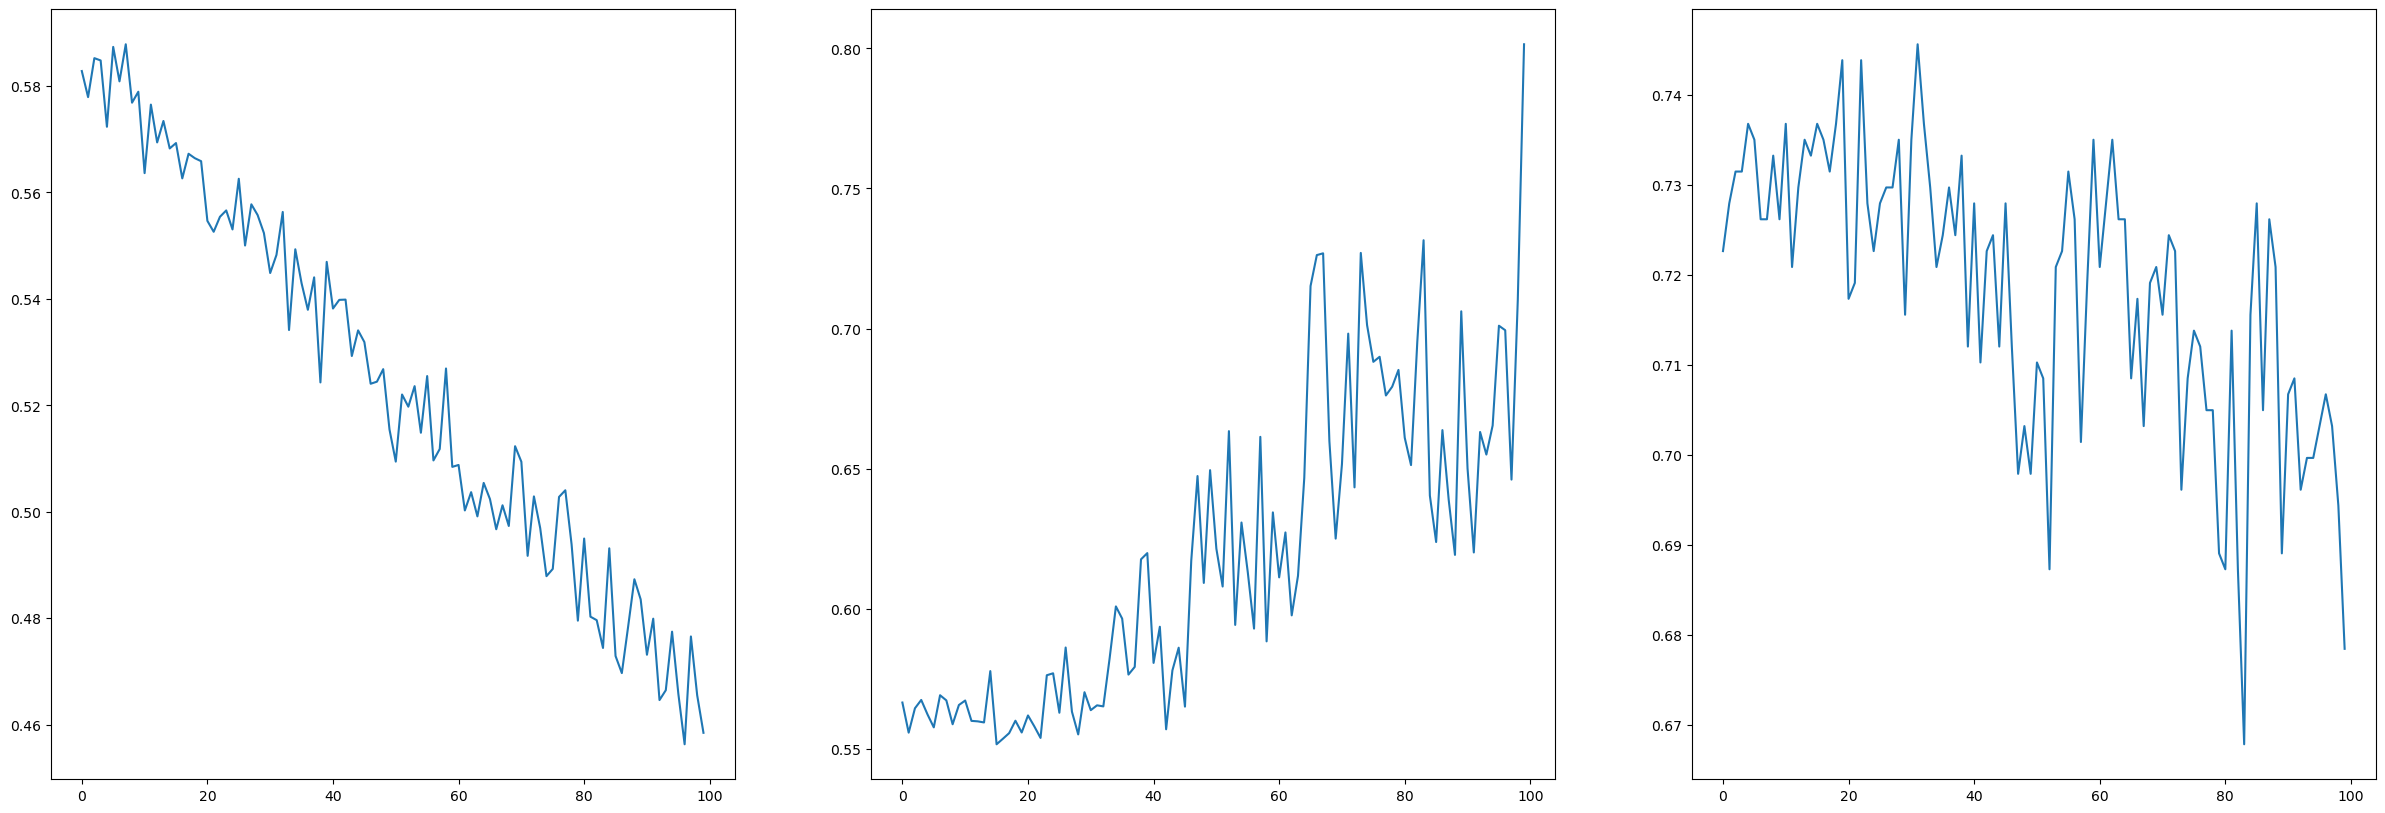

In [10]:
latest = tf.train.latest_checkpoint('/home/jj/FYP/Checkpoint/EfficientNet_ddsm/fine_tuning_checkpoint_loss')
model.load_weights(latest)
init_lr = 5e-6
steps = 1e5
final_lr = 1e-7
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay( init_lr
                                                            ,steps
                                                            ,final_lr
                                                            ,power=0.5)
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-150]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 5e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_loss/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
checkpoint_path_2 = "/home/jj/FYP/Checkpoint/EfficientNet_ddsm/full_model_checkpoint_acc/cp-{epoch:04d}.ckpt"
cp_callback_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2, 
    verbose=1, 
    monitor='val_binary_accuracy',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback_loss,cp_callback_acc]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])